In [1]:
from __future__ import print_function
import pylab

import numpy as np

import matplotlib.pyplot as plt
import time
import os
import pickle
import random

import pandas as pd

import random

#from category_encoders import *

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

plt.style.use('seaborn-white')

pylab.ion()

In [2]:
import scipy.integrate as integrate
from numpy import sqrt, sin, cos, pi, tan, sinh, cosh, exp, tanh, log, log10
import scipy.special as ssf
import math

In [3]:
from multiprocessing import Pool
from multiprocessing import cpu_count
import emcee
from tqdm import tqdm

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

40 CPUs


In [4]:
def make_lower(side_len):
    mask = np.zeros((side_len, side_len), dtype = np.intc)
    for i in range(side_len):
        for j in range(i+1):
            mask[i, j] = 1
    mask = torch.from_numpy(mask)
    return mask

def make_diag(side_len):
    mask = np.zeros((side_len, side_len), dtype = np.intc)
    for i in range(side_len):
        mask[i, i] = 1
    mask = torch.from_numpy(mask)
    return mask

In [5]:
def psiHOpoint(n, x):
    return exp(-0.5*x*x)*ssf.hermite(n)(x)/sqrt(math.factorial(n)*sqrt(pi)*2**n)

def psiHO(n, x):
    x=np.array(x)
    return exp(-0.5*x*x)*ssf.hermite(n)(x)/sqrt(math.factorial(n)*sqrt(pi)*2**n)

def psiHOall(n, x):
    return np.array([psiHO(i, x) for i in range(n+1)])

def HM(n, x):
    return np.array([psiHO(i, x) for i in range(n+1)]).T

def FM(k, L, x): #k Fourier modes in the interval (-L,L)
    x=np.array(x)
    xkmat = np.reshape(x, [len(x),1])*np.array(range(1,k+1))
    zeromode = 1/sqrt(2*L)*np.ones([len(x),1])
    cosmodes = cos(xkmat*pi/L)/sqrt(L)
    sinmodes = sin(xkmat*pi/L)/sqrt(L)
    return np.concatenate((zeromode,cosmodes,sinmodes),axis=1)

def FCpsiHO(n, k, L) :#k Fourier coefficients for the nth harmonic oscillator wavefunction in (-L,L)
    coeff0 = np.array([integrate.quad(lambda x: psiHOpoint(n, x)/sqrt(2*L), -L, L)[0]])
    coeffcos = np.array([integrate.quad(lambda x: psiHOpoint(n, x)*cos(x*i*pi/L)/sqrt(L), -L, L)[0] \
                         for i in range(1,k+1)])
    coeffsin = np.array([integrate.quad(lambda x: psiHOpoint(n, x)*sin(x*i*pi/L)/sqrt(L), -L, L)[0] \
                         for i in range(1,k+1)])
    return np.concatenate((coeff0,coeffcos,coeffsin))

In [6]:
def FM0(k, L, x): #k Fourier modes in the interval (-L,L)
    kvec = np.array(range(1,k+1))
    zeromode = 1/sqrt(2*L)
    cosmodes = cos(kvec*x*pi/L)/sqrt(L)
    sinmodes = sin(kvec*x*pi/L)/sqrt(L)
    return np.concatenate(([zeromode],cosmodes,sinmodes))

def D2FM0(k, L, x): #second derivative of k Fourier modes in the interval (-L,L)
    kvec = np.array(range(1,k+1))
    zeromode = 0
    cosmodes = -(kvec*pi/L)**2*cos(kvec*x*pi/L)/sqrt(L)
    sinmodes = -(kvec*pi/L)**2*sin(kvec*x*pi/L)/sqrt(L)
    return np.concatenate(([zeromode],cosmodes,sinmodes))

def H_HO_FM_int(k, L):
    return np.array([[integrate.quad(lambda x: FM0(k, L, x)[i]*(x**2*FM0(k, L, x)[j]- D2FM0(k, L, x)[j]), -L, L)[0] \
                     for i in range(2*k+1)] for j in range(2*k+1)])

def V_AHO(x):
    return -x**2/2-x+x**4/16

def H_AHO_FM_int(k, L, V): #V is the function that calculates the potential
    return np.array([[integrate.quad(lambda x: FM0(k, L, x)[i]*(2*V(x)*FM0(k, L, x)[j]- D2FM0(k, L, x)[j]), -L, L)[0] \
                     for i in range(2*k+1)] for j in range(2*k+1)])

In [7]:
def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

def K(n):
    upper = -1*np.ones(n-1)
    center = np.concatenate(([1],2*np.ones(n-2),[1]))
    return tridiag(upper,center,upper)

def covHO(n,a):
    upper = -1*np.ones(n-1)
    center = np.concatenate(([1+a**2],(2+a**2)*np.ones(n-2),[1+a**2]))
    return np.linalg.inv(1/a*tridiag(upper,center,upper))

def solveHOE(t,a,b,T):
    t=np.array(t)
    return a*cosh(t) + (-a*cosh(T)/sinh(T) + b/sinh(T))*sinh(t)

In [8]:
def V_AHO(x):
    return -x**2/2-x+x**4/16

def lnprob_V(x, n, a):
    return -np.dot(x,np.dot(K(n),x))/2.0/a - np.sum(a*V_AHO(x))

In [ ]:
T = 2

In [9]:
class QML(nn.Module):
    def __init__(self, n_ES, n_B):
        super(QML, self).__init__()
        
        self.n_Ba = n_B
        self.n_EL = n_ES + 1
        
        self.levels = torch.nn.Parameter(torch.from_numpy(np.random.uniform(1,2,self.n_EL)))
        self.levels.requires_grad = True
        
        self.var_BaC = torch.nn.Parameter(torch.from_numpy(np.random.uniform(-1,1,[self.n_Ba, self.n_EL])))
        self.var_BaC.requires_grad = True
        
        self.mask = (make_lower(self.n_EL) - make_diag(self.n_EL) ) > 0 #convert to boolean
        self.diag = make_diag(self.n_EL) > 0 #convert to boolean   
        
    def forward(self, in_x, in_y):
        
        norms_BaC = torch.linalg.norm(self.var_BaC, dim = 0)
        var_BaC_N = self.var_BaC/norms_BaC
        logits = F.softmin(self.levels, dim = 0)
        
        c_orth = 1000
        loss_orth = c_orth * torch.mean(torch.masked_select(torch.matmul(torch.transpose(var_BaC_N, 0, 1),var_BaC_N) \
                                                                  , self.mask)**2)
        
        loss_ML = -1 * torch.mean(torch.matmul( torch.matmul(in_x, var_BaC_N) * torch.matmul(in_y, var_BaC_N) \
                    , torch.log(logits*(10**4.)+1) ) )
        
        loss = loss_orth + loss_ML
        
        return loss, loss_ML, loss_orth, self.levels, logits 

In [10]:
def main_train_states_QML(G, in_x, in_y, batch_size = 500, epochs = 200000, step = 1e-3):
    n_samples = len(in_x)
        
        
    optimiser = torch.optim.Adam(G.parameters(), lr=step)
    
    
    loss_hist = np.zeros((epochs,), dtype = float)
    loss_ML_hist = np.zeros((epochs,), dtype = float)
    loss_orth_hist = np.zeros((epochs,), dtype = float)
    
    levels_hist = np.zeros((epochs, G.n_EL), dtype = float)
    logits_hist = np.zeros((epochs, G.n_EL), dtype = float)
        
        
    start_time = time.time()
    for i in range(epochs):
        
        idx = np.random.choice(n_samples, batch_size, replace=True)
        #mini_in_x = in_x[idx]
        #mini_in_y = in_y[idx]
                 
        [loss, loss_ML, loss_orth, levels, logits] = G(in_x[idx], in_y[idx])
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        
        loss_hist[i] = loss.tolist()
        loss_ML_hist[i] = loss_ML.tolist()
        loss_orth_hist[i] = loss_orth.tolist()
        
        levels_hist[i, :] = levels.tolist()
        logits_hist[i, :] = logits.tolist()
            
           
        
        if i % 1000 == 0:
                
            print('Batch number ', i)
            print('Loss: ', loss_hist[i])
            print('Loss_orth: ', loss_orth_hist[i])
            print('Loss_ML: ', loss_ML_hist[i])
            print('Logits: ', logits)
            end_time = time.time()
            print('Time taken: {0:.3f} seconds'.format(end_time - start_time))
            start_time = time.time()
            print('@----------------------------------------------------------@')
            #writer.add_summary(summary, i)
            #writer.flush()
                
        
          
                
    var_BaC = G.var_BaC
    norms_BaC = torch.linalg.norm(var_BaC, dim = 0)
    var_BaC_N = (var_BaC / norms_BaC).detach().numpy() #normalise the coefficients of basis states
    levels_hist = np.array(levels_hist)
    logits_hist = np.array(logits_hist)
    
    
    ##Sort energy levels and associated coefficients of basis states in ascending order
    fin_EL = G.levels
    fin_EL = fin_EL.detach()
    fin_logits = F.softmin(fin_EL, dim = 0)
    fin_EL = fin_EL.numpy()
    fin_logits = fin_logits.numpy()
    
    fin_EL_argsort = fin_EL.argsort()
    levels_hist = levels_hist[:, fin_EL_argsort]
    logits_hist = logits_hist[:, fin_EL_argsort]
    var_BaC_N = var_BaC_N[:, fin_EL_argsort]
    fin_EL = fin_EL[fin_EL_argsort]
    fin_logits = fin_logits[fin_EL_argsort]
    #EL_ranks = np.empty_like(fin_EL_argsort)
    #EL_ranks[fin_EL_argsort] = np.arange(len(fin_EL))
    
    return loss_hist, loss_ML_hist, loss_orth_hist, levels_hist, logits_hist, var_BaC_N, fin_EL, fin_logits

In [11]:
infile = "AHO_PI_MCMC_T" + str(T) + ".npy"
paths = np.load(infile)
print(paths.shape)

x = paths[:, 0]
y = paths[:, -1]

del paths

(100000000, 40)


In [12]:
n_Hm = 10
n_EL = 10

in_x = torch.from_numpy(HM(n_Hm, x))
in_y = torch.from_numpy(HM(n_Hm, y))

del x
del y


In [13]:
n_samples = 100000000
batch_size = 500
start_time = time.time()
idx = np.random.choice(n_samples, batch_size, replace=True)
end_time = time.time()
print(end_time-start_time)

0.21246743202209473


In [14]:
epochs = 200000
qml_AHO_HM = QML(n_EL, n_Hm+1)

[loss_hist, loss_ML_hist, loss_orth_hist, levels_hist, logits_hist, var_HC_N, levels_fin, logits_fin] = \
            main_train_states_QML(qml_AHO_HM, in_x, in_y)

/home/scl489/.env/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Batch number  0
Loss:  78.53561612135164
Loss_orth:  81.55740530284908
Loss_ML:  -3.0217891814974345
Logits:  tensor([0.0850, 0.0759, 0.0968, 0.0685, 0.0778, 0.1267, 0.0666, 0.1545, 0.0683,
        0.1117, 0.0683], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 0.687 seconds
@----------------------------------------------------------@
Batch number  1000
Loss:  -4.335557331012867
Loss_orth:  0.08007992685739382
Loss_ML:  -4.415637257870261
Logits:  tensor([0.0591, 0.1281, 0.1314, 0.1394, 0.1102, 0.0487, 0.0499, 0.0769, 0.1107,
        0.1038, 0.0417], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 3.310 seconds
@----------------------------------------------------------@
Batch number  2000
Loss:  -4.079729594337705
Loss_orth:  0.08045661533221773
Loss_ML:  -4.160186209669923
Logits:  tensor([0.0591, 0.1375, 0.1370, 0.1517, 0.1129, 0.0336, 0.0472, 0.0627, 0.1129,
        0.1056, 0.0397], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.830 seconds
@

Batch number  23000
Loss:  -4.5379551011175225
Loss_orth:  0.0006872027910611526
Loss_ML:  -4.538642303908584
Logits:  tensor([0.0113, 0.0872, 0.4665, 0.0566, 0.2117, 0.0025, 0.0031, 0.0033, 0.0297,
        0.1062, 0.0220], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.295 seconds
@----------------------------------------------------------@
Batch number  24000
Loss:  -4.416237133720742
Loss_orth:  0.0006780575999895999
Loss_ML:  -4.416915191320731
Logits:  tensor([0.0111, 0.0856, 0.4679, 0.0555, 0.2142, 0.0024, 0.0031, 0.0030, 0.0299,
        0.1062, 0.0212], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.300 seconds
@----------------------------------------------------------@
Batch number  25000
Loss:  -4.583899481648849
Loss_orth:  0.0009728948364310048
Loss_ML:  -4.58487237648528
Logits:  tensor([0.0110, 0.0873, 0.4674, 0.0552, 0.2135, 0.0024, 0.0030, 0.0031, 0.0296,
        0.1066, 0.0209], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2

Batch number  46000
Loss:  -4.270570002752294
Loss_orth:  0.0013783010301098963
Loss_ML:  -4.271948303782404
Logits:  tensor([0.0103, 0.0811, 0.4675, 0.0527, 0.2152, 0.0023, 0.0029, 0.0029, 0.0315,
        0.1147, 0.0189], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.294 seconds
@----------------------------------------------------------@
Batch number  47000
Loss:  -4.495442961307687
Loss_orth:  0.0006455870702908743
Loss_ML:  -4.496088548377978
Logits:  tensor([0.0106, 0.0804, 0.4654, 0.0536, 0.2158, 0.0024, 0.0030, 0.0031, 0.0315,
        0.1145, 0.0198], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.309 seconds
@----------------------------------------------------------@
Batch number  48000
Loss:  -4.3173770470574295
Loss_orth:  0.000985754651388734
Loss_ML:  -4.318362801708818
Logits:  tensor([0.0108, 0.0810, 0.4668, 0.0538, 0.2122, 0.0023, 0.0029, 0.0031, 0.0327,
        0.1150, 0.0193], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2

Batch number  69000
Loss:  -4.51395638780849
Loss_orth:  0.0007381914562894552
Loss_ML:  -4.514694579264779
Logits:  tensor([0.0105, 0.0798, 0.4681, 0.0531, 0.2116, 0.0024, 0.0025, 0.0034, 0.0324,
        0.1170, 0.0191], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.295 seconds
@----------------------------------------------------------@
Batch number  70000
Loss:  -4.526487239669543
Loss_orth:  0.0008525412359434336
Loss_ML:  -4.5273397809054865
Logits:  tensor([0.0105, 0.0797, 0.4693, 0.0531, 0.2132, 0.0024, 0.0025, 0.0034, 0.0318,
        0.1155, 0.0186], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.289 seconds
@----------------------------------------------------------@
Batch number  71000
Loss:  -4.657051302123794
Loss_orth:  0.0007114817755038699
Loss_ML:  -4.657762783899297
Logits:  tensor([0.0101, 0.0805, 0.4674, 0.0523, 0.2152, 0.0022, 0.0026, 0.0033, 0.0318,
        0.1159, 0.0186], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2

Batch number  92000
Loss:  -4.333906381079419
Loss_orth:  0.0005941238023658928
Loss_ML:  -4.3345005048817855
Logits:  tensor([0.0107, 0.0799, 0.4675, 0.0519, 0.2138, 0.0023, 0.0020, 0.0041, 0.0327,
        0.1162, 0.0189], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.232 seconds
@----------------------------------------------------------@
Batch number  93000
Loss:  -4.101553181493919
Loss_orth:  0.000854360029351481
Loss_ML:  -4.10240754152327
Logits:  tensor([0.0105, 0.0796, 0.4652, 0.0527, 0.2154, 0.0023, 0.0019, 0.0042, 0.0328,
        0.1166, 0.0188], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.223 seconds
@----------------------------------------------------------@
Batch number  94000
Loss:  -4.531428844300556
Loss_orth:  0.0002985742023791347
Loss_ML:  -4.531727418502935
Logits:  tensor([0.0103, 0.0805, 0.4661, 0.0530, 0.2139, 0.0023, 0.0019, 0.0043, 0.0329,
        0.1163, 0.0187], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.

Batch number  115000
Loss:  -4.210563285659675
Loss_orth:  0.0007116926171500541
Loss_ML:  -4.211274978276825
Logits:  tensor([0.0106, 0.0802, 0.4678, 0.0526, 0.2125, 0.0024, 0.0008, 0.0051, 0.0322,
        0.1168, 0.0191], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.275 seconds
@----------------------------------------------------------@
Batch number  116000
Loss:  -4.389270237699173
Loss_orth:  0.0004149102022849233
Loss_ML:  -4.389685147901458
Logits:  tensor([0.0108, 0.0805, 0.4677, 0.0525, 0.2122, 0.0025, 0.0008, 0.0053, 0.0324,
        0.1162, 0.0192], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.276 seconds
@----------------------------------------------------------@
Batch number  117000
Loss:  -4.671684699154703
Loss_orth:  0.0004122179721832798
Loss_ML:  -4.672096917126886
Logits:  tensor([0.0104, 0.0793, 0.4642, 0.0531, 0.2153, 0.0025, 0.0008, 0.0053, 0.0329,
        0.1174, 0.0187], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken

Batch number  138000
Loss:  -4.465819318231721
Loss_orth:  0.0003735756527085002
Loss_ML:  -4.466192893884429
Logits:  tensor([0.0107, 0.0800, 0.4658, 0.0528, 0.2143, 0.0026, 0.0006, 0.0052, 0.0336,
        0.1157, 0.0187], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.270 seconds
@----------------------------------------------------------@
Batch number  139000
Loss:  -4.527125525252752
Loss_orth:  0.0007922133717469953
Loss_ML:  -4.527917738624499
Logits:  tensor([0.0106, 0.0810, 0.4621, 0.0533, 0.2146, 0.0026, 0.0006, 0.0052, 0.0330,
        0.1180, 0.0191], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.282 seconds
@----------------------------------------------------------@
Batch number  140000
Loss:  -4.545896254107007
Loss_orth:  0.0003406488097741441
Loss_ML:  -4.546236902916782
Logits:  tensor([0.0101, 0.0798, 0.4658, 0.0537, 0.2146, 0.0024, 0.0005, 0.0051, 0.0325,
        0.1168, 0.0186], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken

Batch number  161000
Loss:  -4.705155027630515
Loss_orth:  0.0005315365684953399
Loss_ML:  -4.70568656419901
Logits:  tensor([0.0106, 0.0793, 0.4640, 0.0529, 0.2146, 0.0025, 0.0006, 0.0052, 0.0329,
        0.1182, 0.0191], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.268 seconds
@----------------------------------------------------------@
Batch number  162000
Loss:  -4.361384397755533
Loss_orth:  0.000521268981034384
Loss_ML:  -4.361905666736567
Logits:  tensor([0.0104, 0.0797, 0.4655, 0.0529, 0.2154, 0.0025, 0.0006, 0.0052, 0.0322,
        0.1167, 0.0187], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.266 seconds
@----------------------------------------------------------@
Batch number  163000
Loss:  -4.787010315774735
Loss_orth:  0.0005797375678314048
Loss_ML:  -4.787590053342567
Logits:  tensor([0.0105, 0.0800, 0.4688, 0.0526, 0.2122, 0.0025, 0.0006, 0.0050, 0.0324,
        0.1169, 0.0185], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 

Batch number  184000
Loss:  -4.267445919449001
Loss_orth:  0.0004607724470580438
Loss_ML:  -4.267906691896059
Logits:  tensor([0.0108, 0.0793, 0.4659, 0.0527, 0.2146, 0.0027, 0.0006, 0.0053, 0.0325,
        0.1168, 0.0188], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.292 seconds
@----------------------------------------------------------@
Batch number  185000
Loss:  -4.433799688796378
Loss_orth:  0.0005966815800310675
Loss_ML:  -4.434396370376409
Logits:  tensor([0.0103, 0.0792, 0.4696, 0.0524, 0.2124, 0.0026, 0.0006, 0.0054, 0.0325,
        0.1166, 0.0185], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken: 2.298 seconds
@----------------------------------------------------------@
Batch number  186000
Loss:  -4.592968550143513
Loss_orth:  0.0009640736932987538
Loss_ML:  -4.593932623836811
Logits:  tensor([0.0107, 0.0794, 0.4665, 0.0531, 0.2132, 0.0027, 0.0006, 0.0053, 0.0329,
        0.1164, 0.0193], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
Time taken

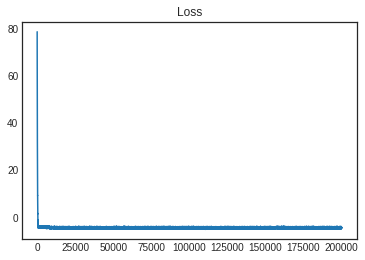

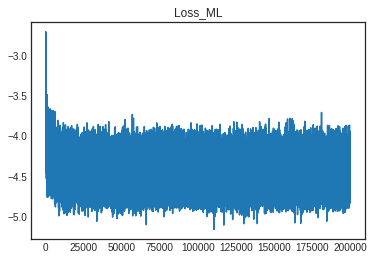

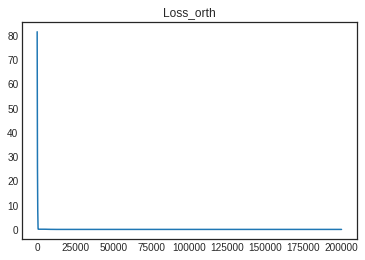

In [15]:
plt.plot(np.arange(epochs), loss_hist)
plt.title("Loss")
plt.show()
plt.plot(np.arange(epochs), loss_ML_hist)
plt.title("Loss_ML")
plt.show()
plt.plot(np.arange(epochs), loss_orth_hist)
plt.title("Loss_orth")
plt.show()

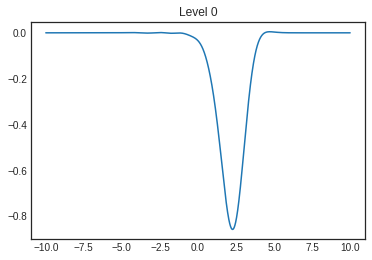

Square integrated over the region: 1.000000000000022


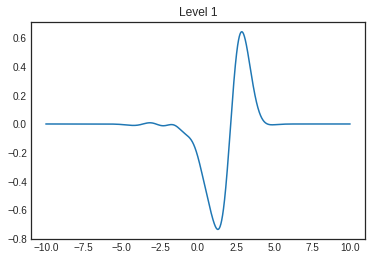

Square integrated over the region: 1.000000000000022


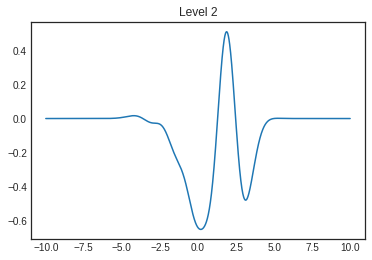

Square integrated over the region: 1.0000000000000218


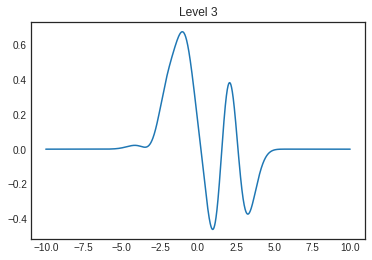

Square integrated over the region: 1.0000000000000213


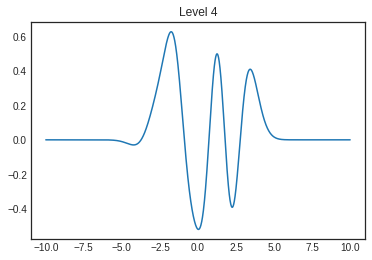

Square integrated over the region: 1.0000000000000215


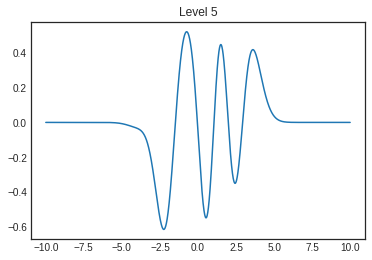

Square integrated over the region: 1.000000000000022


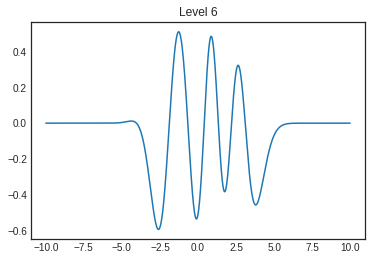

Square integrated over the region: 1.0000000000000222


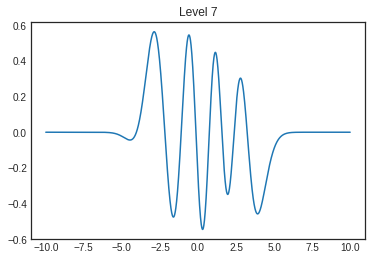

Square integrated over the region: 1.0000000000000224


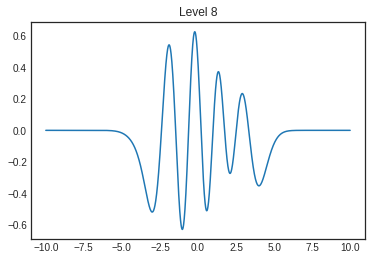

Square integrated over the region: 1.0000000000000222


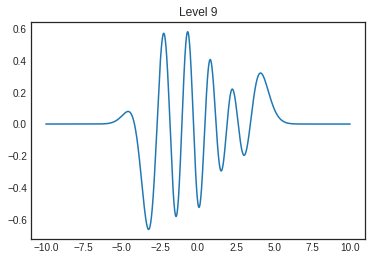

Square integrated over the region: 1.0000000000000224


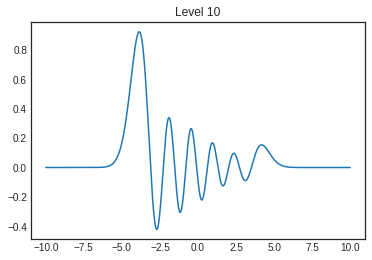

Square integrated over the region: 1.000000000000023


In [16]:
x = np.arange(-10, 10 , 0.01)

Y = HM(n_Hm, x)

SUP = np.matmul(Y, var_HC_N)

for i in range(n_EL+1):
    plt.plot(x, SUP[:, i])
    plt.title("Level " + str(i))
    plt.show()
    print("Square integrated over the region: " + str(np.sum(SUP[:, i] * SUP[:, i]) * 0.01)) #check wavefunction normalisation

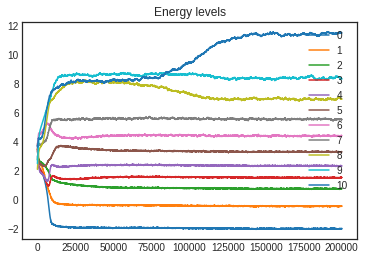

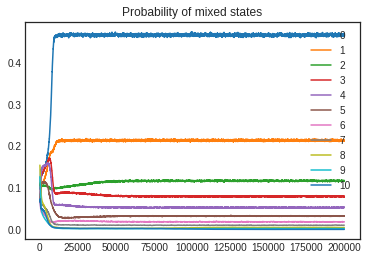

In [18]:
T = 2

for i in range(n_EL+1):
    plt.plot(np.arange(epochs), levels_hist[:,i]*T, label = str(i))

plt.title("Energy levels")    
plt.legend()
plt.show()

for i in range(n_EL+1):
    plt.plot(np.arange(epochs), logits_hist[:,i], label = str(i))

plt.title("Probability of mixed states")    
plt.legend()
plt.show()

In [19]:
print("Energy: ")
print(levels_fin)
print("Probabilities: ")
print(logits_fin)

Energy: 
[-1.01068776 -0.22676838  0.37675231  0.76092441  1.16630244  1.64781439
  2.20927855  2.77370276  3.48490772  4.17295324  5.76354388]
Probabilities: 
[0.46720062 0.21332981 0.11666641 0.07945149 0.05297227 0.03272884
 0.01866766 0.01061606 0.00521304 0.00261985 0.00053394]


In [20]:
print(np.amax(np.abs(np.matmul(var_HC_N.T, var_HC_N) - np.identity(n_EL+1))))

0.002578240254172994
